In [60]:
import os
import pandas as pd
from torchvision.io import read_image
import random
from PIL import Image
from torch.utils.data import DataLoader, Subset, Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision.transforms as transforms
import numpy as np
import model_structure
import torchvision.models as models
from tqdm import tqdm
path = "/Users/liushiwen/Desktop/大四下/hw2/test_data"
path = "D:\Casper\OTHER\Data\MNIST2\HW2_MNIST_train"
dir_list = os.listdir(path)

print(f"Files and directories in '{path}':")
# for item in dir_list:
#     print(item)


class CustomImageDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.image_files = [f for f in os.listdir(data_folder) if f.endswith(".png")]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_folder, self.image_files[idx])
        image = read_image(image_path)
        image = image[0:3].float()
        # image = image.reshape(1, 128, 128)
        
        txt_file = os.path.splitext(self.image_files[idx])[0] + ".txt"
        txt_path = os.path.join(self.data_folder, txt_file)
        with open(txt_path, "r") as f:
            first_line = f.readline().strip()
            class_label = int(first_line.split()[0])

        if self.transform:
            image = self.transform(image)

        return image, class_label
    
def get_dataloaders(data_folder, transform, train_ratio, val_ratio, batch_size):
    # Create a single merged dataset
    train_dataset = CustomImageDataset(data_folder, transform)
    val_dataset = CustomImageDataset(data_folder, transform)
    test_dataset = CustomImageDataset(data_folder, transform)

    # obtain training indices that will be used for validation
    num_train = len(test_dataset)
    indices = list(range(num_train))
    print("--------- INDEX checking ---------")
    print(f"Original: {indices[:5]}")
    random.shuffle(indices)
    print(f"Shuffled: {indices[:5]}")
    print("--------- INDEX shuffled ---------\n")

    split_train = int(np.floor(train_ratio * num_train))
    split_val = split_train + int(np.floor(val_ratio * (num_train-split_train)))
    train_idx, val_idx, test_idx = indices[0:split_train], indices[split_train:split_val], indices[split_val:]
    merge_dataset = Subset(train_dataset, train_idx)

    train_loader = DataLoader(merge_dataset, batch_size=batch_size)
    val_loader = DataLoader(Subset(val_dataset, val_idx), batch_size=batch_size)
    test_loader = DataLoader(Subset(test_dataset, test_idx), batch_size=batch_size)
    
    # check dataset
    print(f"Total number of samples: {num_train} datapoints")
    print(f"Number of train samples: {len(train_loader)} batches/ {len(train_loader.dataset)} datapoints")
    print(f"Number of val samples: {len(val_loader)} batches/ {len(val_loader.dataset)} datapoints")
    print(f"Number of test samples: {len(test_loader)} batches/ {len(test_loader.dataset)} datapoints")
    print(f"Data Transform: {transform}")
    print(f"")
    
    dataloaders = {
        "train": train_loader,
        "val": val_loader,
        "test": test_loader,
    }
    return dataloaders
transform = transforms.Compose([transforms.Resize((128, 128)),])
data_folder = path
custom_dataset = CustomImageDataset(data_folder, transform)
loaders = get_dataloaders(data_folder, transform, 0.1, 0.5, 1)


Files and directories in 'D:\Casper\OTHER\Data\MNIST2\HW2_MNIST_train':


--------- INDEX checking ---------
Original: [0, 1, 2, 3, 4]
Shuffled: [89076, 160, 54373, 72088, 46884]
--------- INDEX shuffled ---------

Total number of samples: 97396 datapoints
Number of train samples: 9739 batches/ 9739 datapoints
Number of val samples: 43828 batches/ 43828 datapoints
Number of test samples: 43829 batches/ 43829 datapoints
Data Transform: Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
)



torch.Size([50, 1])


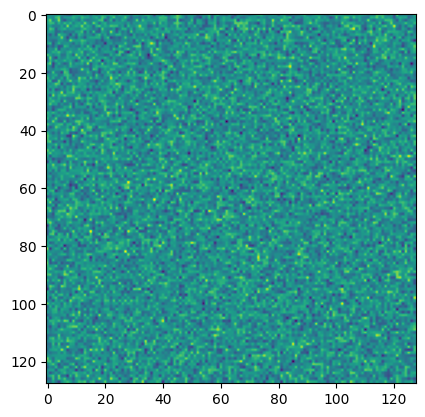

In [7]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
class ImageDownsizer(nn.Module):
    def __init__(self):
        super(ImageDownsizer, self).__init__()
        # Use Adaptive Average Pooling to reduce the image to 1x1
        self.downsize = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(in_features=1, out_features=1)
    
    def forward(self, x):
        x = self.downsize(x)
        # Flatten the output to get a single value per image in the batch
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

# Example usage:
model = ImageDownsizer()

# Assuming input images are grayscale with shape (batch_size, channels, height, width)
# Example input tensor with a batch size of 1, and 1 color channel (grayscale)
input_tensor = torch.randn(50, 1, 128, 128)
plt.imshow(input_tensor[0][0])
plt.
# Get the downsized output
output = model(input_tensor)
print(output.shape)  # Should print torch.Size([1, 1]), indicating 1 value in


finished


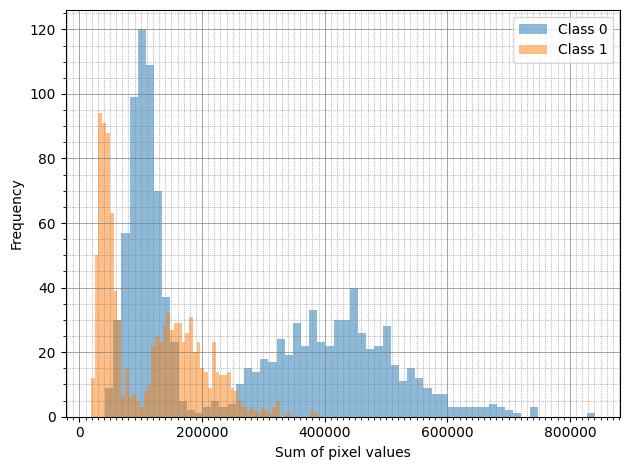

In [61]:
import matplotlib.ticker as ticker
def analyze_pixel_distribution(dataloader):
    class_pixel_sums = {}
    
    # Iterate through the DataLoader
    for images, labels in dataloader:
        for img, label in zip(images, labels):
            # Sum the pixel values of the current image
            pixel_sum = img.sum().item()
            
            # Append the pixel sum to the corresponding class entry in the dictionary
            if label.item() not in class_pixel_sums:
                class_pixel_sums[label.item()] = []
            class_pixel_sums[label.item()].append(pixel_sum)
    print('finished')
    # Plotting the distribution of pixel sums for each class
    fig, ax = plt.subplots()
    for class_label, pixel_sums in class_pixel_sums.items():
        if class_label == 0 or class_label == 1:
            ax.hist(pixel_sums, bins=60, alpha=0.5, label=f'Class {class_label}')
    
    ax.set_xlabel('Sum of pixel values')
    ax.set_ylabel('Frequency')
    ax.legend()

    # Setting smaller units and adding a grid
    ax.minorticks_on()  # Enable minor ticks
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=20)) # n=5 means 4 minor grid lines between major ticks
    # ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    
    plt.tight_layout()  # Adjust layout to not overlap
    plt.show()



analyze_pixel_distribution(loaders['train'])


Finished gathering data.


KeyboardInterrupt: 

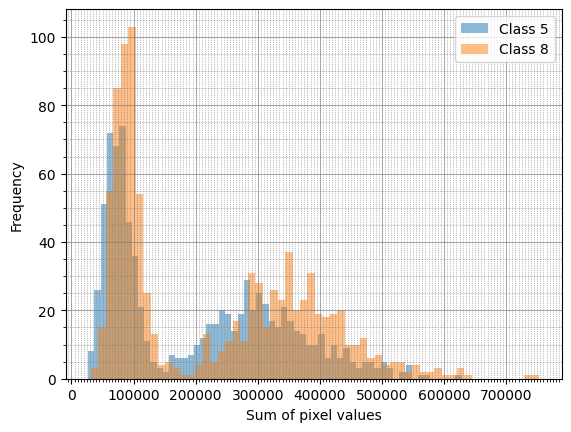

In [62]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def analyze_and_compare_pixel_distribution(dataloader):
    class_pixel_sums = {}

    # Iterate through the DataLoader
    for images, labels in dataloader:
        for img, label in zip(images, labels):
            # Sum the pixel values of the current image
            pixel_sum = img.sum().item()

            # Append the pixel sum to the corresponding class entry in the dictionary
            if label.item() not in class_pixel_sums:
                class_pixel_sums[label.item()] = []
            class_pixel_sums[label.item()].append(pixel_sum)

    print('Finished gathering data.')

    # Generate and save plots for comparisons between each class
    classes = sorted(class_pixel_sums.keys())
    for i in range(len(classes)):
        for j in range(i + 1, len(classes)):
            fig, ax = plt.subplots()
            ax.hist(class_pixel_sums[classes[i]], bins=60, alpha=0.5, label=f'Class {classes[i]}')
            ax.hist(class_pixel_sums[classes[j]], bins=60, alpha=0.5, label=f'Class {classes[j]}')

            ax.set_xlabel('Sum of pixel values')
            ax.set_ylabel('Frequency')
            ax.legend()

            # Setting smaller units and adding a grid
            ax.minorticks_on()  # Enable minor ticks
            ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=20))  # More dense minor grid lines
            ax.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
            ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

            plt.tight_layout()

            # Save the plot
            plt.savefig(f'pixel_distribution_{classes[i]}_vs_{classes[j]}.png')
            plt.close()

# Example usage:
# Assuming 'train_loader' is your DataLoader
analyze_and_compare_pixel_distribution(loaders['train'])


In [50]:
# threshold = 58000  # Adjust this based on your observation of pixel sums
# correct_predictions = 0
# total_images = 0
def thresholding(threshold):
    total_images = 0
    correct_predictions = 0
    for images, labels in tqdm(loaders['train']):
        pixel_sum = images.sum().item()
        
        # Predict class based on the sum
        if pixel_sum < threshold:
            predicted_class = 1
        else:
            # Randomly choose among classes 0 and 2-9
            # predicted_class = np.random.choice([0] + list(range(2, 10)))
            predicted_class = 0

        # Update accuracy tracking
        total_images += 1
        if predicted_class == labels.item():
            correct_predictions += 1

    # Calculate and print accuracy
    accuracy = correct_predictions / total_images
    print(f"Accuracy: {accuracy*100:.2f}%, threshold: {threshold}")
thresholding(58000)
thresholding(57000)
thresholding(56000)
thresholding(55000)

100%|██████████| 97396/97396 [04:49<00:00, 336.38it/s]


Accuracy: 15.64%, threshold: 58000


100%|██████████| 97396/97396 [00:49<00:00, 1985.17it/s]


Accuracy: 15.56%, threshold: 57000


100%|██████████| 97396/97396 [00:49<00:00, 1949.71it/s]


Accuracy: 15.48%, threshold: 56000


100%|██████████| 97396/97396 [00:53<00:00, 1835.77it/s]

Accuracy: 15.38%, threshold: 55000


In [51]:
sum = [0,0,0,0,0,
       0,0,0,0,0,]
for images, labels in tqdm(loaders['train']):
    sum[labels.item()]+=1


100%|██████████| 97396/97396 [00:45<00:00, 2143.05it/s]


In [59]:
all_sum = 0
for ii in range(10):
    print(f"{ii}: {sum[ii]}/ {sum[ii] *100 // 97396}%")
    # all_sum += sum[ii]
# print(all_sum)

0: 10785/ 11%
1: 10835/ 11%
2: 9531/ 9%
3: 9812/ 10%
4: 9314/ 9%
5: 8687/ 8%
6: 9474/ 9%
7: 10007/ 10%
8: 9427/ 9%
9: 9524/ 9%


In [47]:
threshold = 56000  # Adjust this based on your observation of pixel sums
correct_predictions = 0
total_images = 0

for images, labels in tqdm(loaders['train']):
    pixel_sum = images.sum().item()
    
    # Predict class based on the sum
    if pixel_sum < threshold:
        predicted_class = 1
    else:
        # Randomly choose among classes 0 and 2-9
        predicted_class = np.random.choice([0] + list(range(2, 10)))

    # Update accuracy tracking
    if labels.item() == 1:
        total_images += 1
        if predicted_class == labels.item():
            correct_predictions += 1

# Calculate and print accuracy
accuracy = correct_predictions / total_images
print(f"Accuracy: {accuracy*100:.2f}%")

100%|██████████| 9739/9739 [00:06<00:00, 1578.96it/s]

Accuracy: 41.24%
